# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="https://github.com/schatterjeecs/capst_recomendation/blob/master/pic1.png?raw=1"/>

Then you will want to run the above command:

<img src="https://github.com/schatterjeecs/capst_recomendation/blob/master/pic2.png?raw=1"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
!git clone https://github.com/schatterjeecs/capst_recomendation.git

fatal: destination path 'capst_recomendation' already exists and is not an empty directory.


In [4]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
profile = profile[(profile['age']<100) & (profile['gender']!=None)]

In [7]:
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [8]:
len(profile)

14808

In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
len(transcript)

306534

In [11]:
combo = pd.merge(profile, transcript, how='inner', left_on=['id'], right_on=['person']).rename(columns={'id': 'person_id'})

In [12]:
len(combo)

272430

In [13]:
combo.head()

,gender,age,person_id,became_member_on,income,person,event,value,time
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528


In [14]:
combo['age'].value_counts()

58    7546
53    6688
51    6559
54    6546
57    6468
      ... 
95     369
97     239
96     135
99      99
98      85
Name: age, Length: 82, dtype: int64

In [15]:
offer_df = pd.json_normalize(combo['value'])

In [16]:
offer_df.head()

,amount,offer id,offer_id,reward
0,21.51,NaN,NaN,NaN
1,32.28,NaN,NaN,NaN
2,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
3,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,23.22,NaN,NaN,NaN


**value**: in order to clean up inconsitent name 'offer_id' & 'offer id'

In [17]:
offer_df['off_id'] = offer_df['offer id'].combine_first(offer_df['offer_id'])

In [18]:
offer_df.head(10)

,amount,offer id,offer_id,reward,off_id
0,21.51,NaN,NaN,NaN,NaN
1,32.28,NaN,NaN,NaN,NaN
2,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,23.22,NaN,NaN,NaN,NaN
5,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
7,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,19.89,NaN,NaN,NaN,NaN
9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [19]:
combo_df = pd.concat([combo, offer_df], axis=1)

In [20]:
combo_df.head(20)

,gender,age,person_id,became_member_on,income,person,event,value,time,amount,offer id,offer_id,reward,off_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18,21.51,NaN,NaN,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144,32.28,NaN,NaN,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528,23.22,NaN,NaN,NaN,NaN
5,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,528,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
6,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
7,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,19.89,NaN,NaN,NaN,NaN
9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [21]:
df_offer_final = pd.merge(combo_df, portfolio, how='inner', left_on=['off_id'], right_on=['id']).rename(columns={'reward_y': 'reward'})

In [22]:
df_offer_final.head(3)

,gender,age,person_id,became_member_on,income,person,event,value,time,amount,offer id,offer_id,reward_x,off_id,reward,channels,difficulty,duration,offer_type,id
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,528,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9


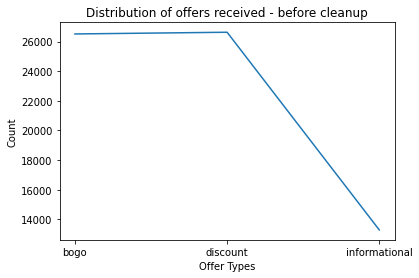

In [85]:
plt.plot(df_offer_final[df_offer_final['event']=='offer received'].groupby(['offer_type']).count()['person_id'])
plt.ylabel('Count')
plt.xlabel('Offer Types')
plt.title('Distribution of offers received - before cleanup');

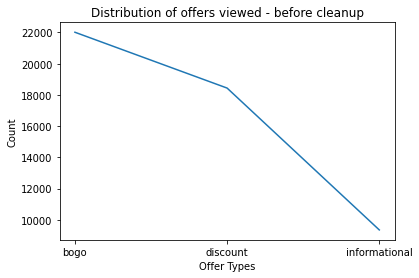

In [86]:
plt.plot(df_offer_final[df_offer_final['event']=='offer viewed'].groupby(['offer_type']).count()['person_id'])
plt.ylabel('Count')
plt.xlabel('Offer Types')
plt.title('Distribution of offers viewed - before cleanup');

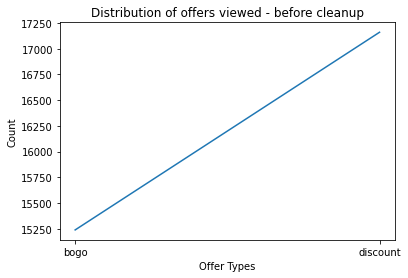

In [87]:
plt.plot(df_offer_final[df_offer_final['event']=='offer completed'].groupby(['offer_type']).count()['person_id'])
plt.ylabel('Count')
plt.xlabel('Offer Types')
plt.title('Distribution of offers viewed - before cleanup');

In [23]:
df_offer_final = df_offer_final[['age', 'became_member_on', 'gender',
                                 'person_id', 'income', 'event', 'time', 'off_id', 'channels', 
                                'difficulty', 'duration', 'offer_type', 'reward']]

In [24]:
df_offer_final.head(3)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
2,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5


In [25]:
df_offer_final.loc[(df_offer_final['age'] < 20), 'age_group'] = 'UNDER_20'
df_offer_final.loc[(df_offer_final['age'] >= 20) & (df_offer_final['age'] <= 40), 'age_group'] = '20_40'
df_offer_final.loc[(df_offer_final['age'] > 40) & (df_offer_final['age'] <= 60), 'age_group'] = '41_60'
df_offer_final.loc[(df_offer_final['age'] > 60) & (df_offer_final['age'] <= 80), 'age_group'] = '61_80'
df_offer_final.loc[(df_offer_final['age'] > 80), 'age_group'] = 'ABOVE_80'

In [26]:
df_offer_final.head(2)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60


In [27]:
from datetime import datetime
current_year_month = int(datetime.today().strftime("%Y%m"))
current_year_month

202109

In [28]:
df_offer_final['membership_age'] = current_year_month - df_offer_final['became_member_on'].apply(lambda x: int(str(x)[:6]))

In [29]:
df_grouped = pd.DataFrame(
    df_offer_final.groupby(['person_id','off_id']).count()['age'])
df_grouped = df_grouped.rename(columns={"age":"count"})
df_grouped_agg = pd.DataFrame(df_offer_final.groupby(['person_id','off_id'])['event'].agg(list))
df_grouped_agg = df_grouped_agg.rename(columns={"event": "event_lst"})
df_grouped = pd.merge(df_grouped, df_grouped_agg, how='inner', left_on=['person_id', 'off_id'],
                    right_on=['person_id', 'off_id'])
df_grouped.head(2)

count                          event_lst
person_id                        off_id                                                                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      2  [offer received, offer completed]
                                 3f207df678b143eea3cee63160fa8bed      2     [offer received, offer viewed]

In [30]:
df_final = pd.merge(df_offer_final, df_grouped, how='inner', left_on=['person_id', 'off_id'],
                    right_on=['person_id', 'off_id'])

In [31]:
df_final.head(2)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age,count,event_lst
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,402,2,"[offer received, offer completed]"
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,402,2,"[offer received, offer completed]"


In [32]:
df_final.count()

age                 148628
became_member_on    148628
gender              148628
person_id           148628
income              148628
event               148628
time                148628
off_id              148628
channels            148628
difficulty          148628
duration            148628
offer_type          148628
reward              148628
age_group           148628
membership_age      148628
count               148628
event_lst           148628
dtype: int64

In [33]:
df_completed = df_final[df_final['event']=='offer completed']

In [34]:
df_completed['person_id'].values

array(['0610b486422d4921ae7d2bf64640c50b',
       '78afa995795e4d85b5d9ceeca43f5fef',
       'e2127556f4f64592b11af22de27a7932', ...,
       '122c0c2a3c2540848f8c3fdc37e97639',
       '54bead4179c44b71acc4e8398181d183',
       '9dc1421481194dcd9400aec7c9ae6366'], dtype=object)

In [35]:
df = df_final[~df_final['person_id'].isin(df_completed['person_id'].values)]

In [36]:
df.count()

age                 20032
became_member_on    20032
gender              20032
person_id           20032
income              20032
event               20032
time                20032
off_id              20032
channels            20032
difficulty          20032
duration            20032
offer_type          20032
reward              20032
age_group           20032
membership_age      20032
count               20032
event_lst           20032
dtype: int64

In [37]:
df.head(10)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age,count,event_lst
16,61,20180501,F,a448667f336b42c9a66fc5ffd5d73772,40000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,304,1,[offer received]
68,62,20180410,F,ffc6c9fbe34b4578911dcdf6745b4c74,57000.0,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,305,2,"[offer received, offer viewed]"
69,62,20180410,F,ffc6c9fbe34b4578911dcdf6745b4c74,57000.0,offer viewed,174,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,305,2,"[offer received, offer viewed]"
83,74,20180712,M,e641af076cc54529bec6ab61fc25f4a6,48000.0,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,302,2,"[offer received, offer viewed]"
84,74,20180712,M,e641af076cc54529bec6ab61fc25f4a6,48000.0,offer viewed,252,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,302,2,"[offer received, offer viewed]"
90,26,20171211,M,e997a086fc13446da2aa9070d98d191a,71000.0,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,20_40,397,1,[offer received]
91,43,20170915,M,bf8d7498eb32431ab3fedaa14b7d3a0d,70000.0,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,400,2,"[offer received, offer viewed]"
92,43,20170915,M,bf8d7498eb32431ab3fedaa14b7d3a0d,70000.0,offer viewed,222,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,400,2,"[offer received, offer viewed]"
103,20,20180528,M,220a39cdfd6b41268c43a2e588fcb7e0,69000.0,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,20_40,304,1,[offer received]
107,72,20180601,M,1827da57bb924833a6f73c79b5f2bbc5,33000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,303,1,[offer received]


In [38]:
df_received = df[df['event'] == 'offer received']

In [39]:
df = df_completed.append(df_received)
df = df.join(df.channels.str.join('|').str.get_dummies())
df = df.join(df.offer_type.str.get_dummies())
df = df.join(df.age_group.str.get_dummies())
df = df.join(df.gender.str.get_dummies())
df['event_enc'] = df['event'].map({'offer received':0, 'offer completed':1})

In [40]:
df.head(3)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age,count,event_lst,email,mobile,social,web,bogo,discount,informational,20_40,41_60,61_80,ABOVE_80,UNDER_20,F,M,O,event_enc
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,402,2,"[offer received, offer completed]",1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1
4,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,404,3,"[offer received, offer viewed, offer completed]",1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1
7,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer completed,522,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,305,3,"[offer received, offer viewed, offer completed]",1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1


In [41]:
df['event_enc'].value_counts()

1    32399
0    12104
Name: event_enc, dtype: int64

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt


In [43]:
df.age.describe()

count    44503.000000
mean        54.420691
std         17.361393
min         18.000000
25%         43.000000
50%         55.000000
75%         67.000000
max         99.000000
Name: age, dtype: float64

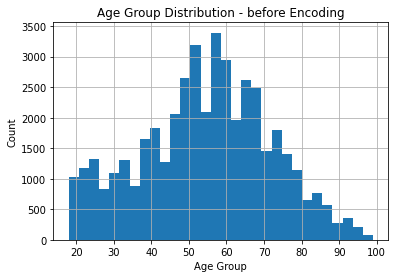

In [46]:
df.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution - before Encoding');

In [47]:
df['age_group'].value_counts()

41_60       17962
61_80       13758
20_40        9245
ABOVE_80     2919
UNDER_20      619
Name: age_group, dtype: int64

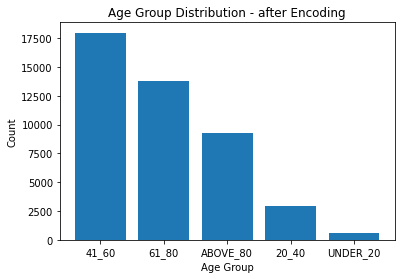

In [48]:
plt.bar(df['age_group'].unique(), df['age_group'].value_counts())
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution - after Encoding');
plt.show()

In [54]:
df.income.describe()

count     44503.000000
mean      65471.361481
std       21573.297288
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

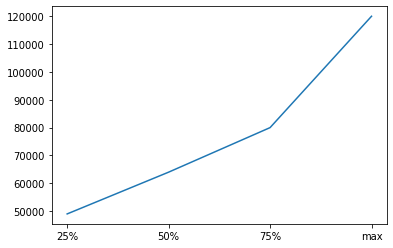

In [60]:
plt.plot(df.income.describe()[['25%', '50%', '75%', 'max']])

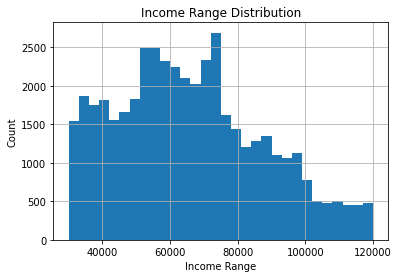

In [51]:
df.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

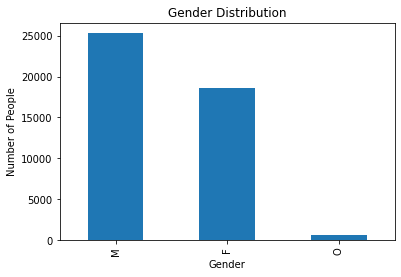

In [61]:
gend = df.gender.value_counts()
gend.plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

In [64]:
df.event.value_counts()

offer completed    32399
offer received     12104
Name: event, dtype: int64

In [70]:
df.groupby(['event', 'offer_type']).count()['person_id']

event            offer_type   
offer completed  bogo             15239
                 discount         17160
offer received   bogo              4703
                 discount          4459
                 informational     2942
Name: person_id, dtype: int64

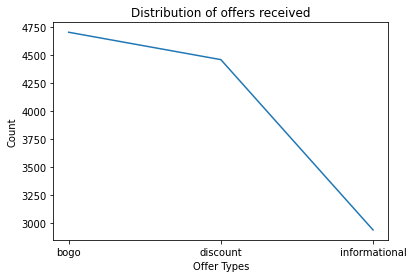

In [80]:
plt.plot(df[df['event']=='offer received'].groupby(['offer_type']).count()['person_id'])
plt.ylabel('Count')
plt.xlabel('Offer Types')
plt.title('Distribution of offers received');

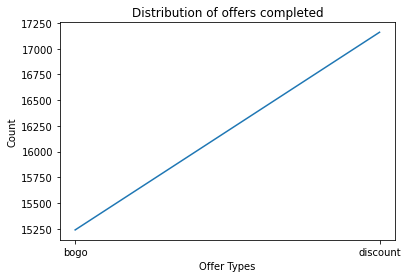

In [82]:
plt.plot(df[df['event']=='offer completed'].groupby(['offer_type']).count()['person_id'])
plt.ylabel('Count')
plt.xlabel('Offer Types')
plt.title('Distribution of offers completed');

In [ ]:
X = df.drop(columns=['age', 'became_member_on',	'gender',	'person_id',	'event',	'off_id',	
                     'offer_type', 'channels', 'age_group', 'event_lst', 'event_enc', 'count'], axis=1)
y = df['event_enc']

In [ ]:
X.head(3)

,income,time,difficulty,duration,reward,membership_age,email,mobile,social,web,bogo,discount,informational,20_40,41_60,61_80,ABOVE_80,UNDER_20,F,M,O
1,112000.0,528,5,7,5,402,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0
4,100000.0,132,5,7,5,404,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0
7,70000.0,522,5,7,5,305,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0


In [ ]:
y.head(3)

1    1
4    1
7    1
Name: event_enc, dtype: int64

In [ ]:
X.columns

Index(['income', 'time', 'difficulty', 'duration', 'reward', 'membership_age',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       '20_40', '41_60', '61_80', 'ABOVE_80', 'UNDER_20', 'F', 'M', 'O'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_enc = scaler.fit_transform(X)
y_enc = y.values

In [ ]:
X_enc

array([[0.91111111, 0.7394958 , 0.25      , ..., 1.        , 0.        ,
        0.        ],
       [0.77777778, 0.18487395, 0.25      , ..., 1.        , 0.        ,
        0.        ],
       [0.44444444, 0.73109244, 0.25      , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.05555556, 0.47058824, 0.5       , ..., 0.        , 1.        ,
        0.        ],
       [0.38888889, 0.        , 0.5       , ..., 1.        , 0.        ,
        0.        ],
       [0.26666667, 0.47058824, 0.5       , ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
y_enc

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
X_enc.shape

(44503, 21)

In [ ]:
y_enc.shape

(44503,)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape

(35602, 21)

In [ ]:
y_train.shape

(35602,)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

In [ ]:
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.25      0.39      2400
           1       0.78      1.00      0.88      6501

    accuracy                           0.79      8901
   macro avg       0.87      0.62      0.64      8901
weighted avg       0.83      0.79      0.75      8901



In [ ]:
df.head(2)

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age,count,event_lst,email,mobile,social,web,bogo,discount,informational,20_40,41_60,61_80,ABOVE_80,UNDER_20,F,M,O,event_enc
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,41_60,402,2,"[offer received, offer completed]",1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1
4,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,61_80,404,3,"[offer received, offer viewed, offer completed]",1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [ ]:
prof = [{"gender": "M", "age": 32, "id": "0b486422d4921ae7d2", 
                            "became_member_on": "20210627", "income": 20982322},
                            {"gender": "F", "age": 31, "id": "0b4864225645ae7d2", 
                            "became_member_on": "20210627", "income": 342324}]
new_profile = pd.DataFrame(prof)
trans = [{"person": "0b486422d4921ae7d2", "event": "offer received", "time": 0,
                                "value": {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}}, 
         {"person": "0b486422d4921ae7d2", "event": "offer viewed", "time": 10,
                                "value": {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}},
         {"person": "0b486422d4921ae7d2", "event": "offer received", "time": 200,
                                "value": {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}},
         {"person": "0b4864225645ae7d2", "event": "offer received", "time": 0,
                                "value": {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}},
         {"person": "0b4864225645ae7d2", "event": "offer completed", "time": 23,
                                "value": {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}}]
new_transaction = pd.DataFrame.from_dict(trans)

In [ ]:
new_profile

,gender,age,id,became_member_on,income
0,M,32,0b486422d4921ae7d2,20210627,20982322
1,F,31,0b4864225645ae7d2,20210627,342324


In [ ]:
new_transaction

,person,event,time,value
0,0b486422d4921ae7d2,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,0b486422d4921ae7d2,offer viewed,10,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,0b486422d4921ae7d2,offer received,200,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
3,0b4864225645ae7d2,offer received,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
4,0b4864225645ae7d2,offer completed,23,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


In [ ]:
def scale_data(X, y):
  scaler = MinMaxScaler()
  X_enc = scaler.fit_transform(X)
  y_enc = y.values
  return X_enc, y_enc

In [ ]:
def preprocessing(event, customer, transaction):
  cust_trans = pd.merge(customer, transaction, how='inner', left_on=['id'], right_on=['person']).rename(columns={'id': 'person_id'})
  offer_val = pd.json_normalize(cust_trans['value'])
  offer_val['off_id'] = offer_val['offer id'].combine_first(offer_val['offer_id'])
  combo_df = pd.concat([cust_trans, offer_val], axis=1)
  event_combo = pd.merge(combo_df, event, how='inner', left_on=['off_id'], right_on=['id']).rename(columns={'reward_y': 'reward'})
  event_combo = event_combo[['age', 'became_member_on', 'gender',
                                 'person_id', 'income', 'event', 'time', 'off_id', 'channels', 
                                'difficulty', 'duration', 'offer_type', 'reward']]
  event_combo.loc[(event_combo['age'] < 20), 'age_group'] = 'UNDER_20'
  event_combo.loc[(event_combo['age'] >= 20) & (event_combo['age'] <= 40), 'age_group'] = '20_40'
  event_combo.loc[(event_combo['age'] > 40) & (event_combo['age'] <= 60), 'age_group'] = '41_60'
  event_combo.loc[(event_combo['age'] > 60) & (event_combo['age'] <= 80), 'age_group'] = '61_80'
  event_combo.loc[(event_combo['age'] > 80), 'age_group'] = 'ABOVE_80'
  current_year_month = int(datetime.today().strftime("%Y%m"))
  event_combo['membership_age'] = current_year_month - event_combo['became_member_on'].apply(lambda x: int(str(x)[:6]))
  df_completed = event_combo[event_combo['event']=='offer completed']
  df_interim = event_combo[~event_combo['person_id'].isin(df_completed['person_id'].values)]
  df_received = df_interim[df_interim['event'] == 'offer received']
  df = df_completed.append(df_received)

  df = df.join(df.channels.str.join('|').str.get_dummies())
  if 'web' not in df:
    df['web'] = 0
  if 'email' not in df:
    df['email'] = 0
  if 'mobile' not in df:
    df['mobile'] = 0
  if 'social' not in df:
    df['social'] = 0
  
  df = df.join(df.offer_type.str.get_dummies())
  if 'bogo' not in df:
    df['bogo'] = 0
  if 'discount' not in df:
    df['discount'] = 0
  if 'informational' not in df:
    df['informational'] = 0

  df = df.join(df.age_group.str.get_dummies())
  if 'UNDER_20' not in df:
    df['UNDER_20'] = 0
  if '20_40' not in df:
    df['20_40'] = 0
  if '41_60' not in df:
    df['41_60'] = 0
  if '61_80' not in df:
    df['61_80'] = 0
  if 'ABOVE_80' not in df:
    df['ABOVE_80'] = 0
  
  df = df.join(df.gender.str.get_dummies())
  if 'M' not in df:
    df['M'] = 0
  if 'F' not in df:
    df['F'] = 0
  if 'O' not in df:
    df['O'] = 0
  
  df['event_enc'] = df['event'].map({'offer received':0, 'offer completed':1})

  X = df.drop(columns=['age', 'became_member_on',	'gender',	'person_id',	'event',	'off_id',	
                     'offer_type', 'channels', 'age_group', 'event_enc'], axis=1)
  print(X.columns)
  y = df['event_enc']
  print(f"X:\n{X}\ny:\n{y}")
  X_enc, y_enc = scale_data(X, y)
  return df, X_enc, y_enc

**For Training the model**

With columns: 
```
['income', 'time', 'difficulty', 'duration', 'reward', 'membership_age', 'email', 'mobile', 'social', 'web', 'bogo', 'discount',
'informational', '20_40', '41_60', '61_80', 'ABOVE_80', 'UNDER_20', 'F','M', 'O']
```



In [ ]:
transformed_df, X, y= preprocessing(event=portfolio, customer=profile, transaction=transcript)

Index(['income', 'time', 'difficulty', 'duration', 'reward', 'membership_age',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       '20_40', '41_60', '61_80', 'ABOVE_80', 'UNDER_20', 'F', 'M', 'O'],
      dtype='object')
X:
          income  time  difficulty  duration  ...  UNDER_20  F  M  O
1       112000.0   528           5         7  ...         0  1  0  0
4       100000.0   132           5         7  ...         0  1  0  0
7        70000.0   522           5         7  ...         0  0  1  0
12       53000.0   498           5         7  ...         0  0  1  0
15       42000.0   516           5         7  ...         0  0  1  0
...          ...   ...         ...       ...  ...       ... .. .. ..
148595   31000.0   408          10         5  ...         0  1  0  0
148600   64000.0     0          10         5  ...         0  1  0  0
148606   35000.0   336          10         5  ...         0  0  1  0
148621   65000.0     0          10         5  ...   

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape

(35602, 21)

In [ ]:
y_train.shape

(35602,)

In [ ]:
X_test.shape

(8901, 21)

In [ ]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.25      0.39      2400
           1       0.78      1.00      0.88      6501

    accuracy                           0.79      8901
   macro avg       0.87      0.62      0.64      8901
weighted avg       0.83      0.79      0.75      8901



**For prediction on new data**

In [ ]:
transformed_df, X_new, y_new = preprocessing(event=portfolio, customer=new_profile, transaction=new_transaction)

Index(['income', 'time', 'difficulty', 'duration', 'reward', 'membership_age',
       'email', 'mobile', 'web', 'social', 'bogo', 'discount', 'informational',
       '20_40', 'UNDER_20', '41_60', '61_80', 'ABOVE_80', 'F', 'M', 'O'],
      dtype='object')
X:
     income  time  difficulty  duration  reward  ...  61_80  ABOVE_80  F  M  O
3    342324    23           5         7       5  ...      0         0  1  0  0
0  20982322     0           5         7       5  ...      0         0  0  1  0
4  20982322   200          20        10       5  ...      0         0  0  1  0

[3 rows x 21 columns]
y:
3    1
0    0
4    0
Name: event_enc, dtype: int64


In [ ]:
transformed_df

,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age,email,mobile,web,social,bogo,discount,informational,20_40,UNDER_20,41_60,61_80,ABOVE_80,F,M,O,event_enc
3,31,20210627,F,0b4864225645ae7d2,342324,offer completed,23,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,20_40,3,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,1
0,32,20210627,M,0b486422d4921ae7d2,20982322,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,20_40,3,1,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0
4,32,20210627,M,0b486422d4921ae7d2,20982322,offer received,200,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,discount,5,20_40,3,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0


In [ ]:
transformed_df.reset_index()

,index,age,became_member_on,gender,person_id,income,event,time,off_id,channels,difficulty,duration,offer_type,reward,age_group,membership_age,email,mobile,web,social,bogo,discount,informational,20_40,UNDER_20,41_60,61_80,ABOVE_80,F,M,O,event_enc
0,3,31,20210627,F,0b4864225645ae7d2,342324,offer completed,23,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,20_40,3,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,1
1,0,32,20210627,M,0b486422d4921ae7d2,20982322,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,20_40,3,1,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0
2,4,32,20210627,M,0b486422d4921ae7d2,20982322,offer received,200,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,discount,5,20_40,3,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0


In [ ]:
X_new.shape

(2, 21)

In [ ]:
y_new.shape

(2,)

In [ ]:
y_pred_new = classifier.predict(X_new)
y_pred_new

array([1, 1], dtype=int64)

In [ ]:
print(classification_report(y_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def pred(transformed_df, data, actual):
  
  y_pred = classifier.predict(data)
  y_result = y_pred #.map({0: "offer not completed", 1: "offer completed"})
  print(len(y_result))
  result_df = transformed_df.reset_index()[['person_id', 'off_id']]
  print(result_df.count())
  for idx, row in result_df.iterrows():
    result_df['predicted'] = y_result[idx]
    result_df['predicted'] = result_df['predicted'].map({0: "offer not completed", 1: "offer completed"})
  print(classification_report(actual, y_pred))

  print(f"{result_df}")
  unique, count = np.unique(y_pred, return_counts=True)
  freq = np.asarray((unique, count)).T
  print(f"Frequencies: {freq}")

In [ ]:
pred(transformed_df, X_new, y_new)

3
person_id    3
off_id       3
dtype: int64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3

            person_id                            off_id        predicted
0   0b4864225645ae7d2  9b98b8c7a33c4b65b9aebfe6a799e6d9  offer completed
1  0b486422d4921ae7d2  9b98b8c7a33c4b65b9aebfe6a799e6d9  offer completed
2  0b486422d4921ae7d2  0b1e1539f2cc45b7b9fa7c272da2e1d7  offer completed
Frequencies: [[1 3]]
